## This is the softmax workbook for ECE C147/C247 Assignment #2

Please follow the notebook linearly to implement a softmax classifier.

Please print out the workbook entirely when completed.

We thank Serena Yeung & Justin Johnson for permission to use code written for the CS 231n class (cs231n.stanford.edu).  These are the functions in the cs231n folders and code in the jupyer notebook to preprocess and show the images.  The classifiers used are based off of code prepared for CS 231n as well.

The goal of this workbook is to give you experience with training a softmax classifier.

In [1]:
import random
import numpy as np
from cs231n.data_utils import load_CIFAR10
import matplotlib.pyplot as plt

%matplotlib inline
%load_ext autoreload
%autoreload 2

In [9]:
def get_CIFAR10_data(num_training=49000, num_validation=1000, num_test=1000, num_dev=500):
    """
    Load the CIFAR-10 dataset from disk and perform preprocessing to prepare
    it for the linear classifier. These are the same steps as we used for the
    SVM, but condensed to a single function.  
    """
    # Load the raw CIFAR-10 data
    cifar10_dir = 'cifar-10-batches-py' # You need to update this line
    X_train, y_train, X_test, y_test = load_CIFAR10(cifar10_dir)
    
    # subsample the data
    mask = list(range(num_training, num_training + num_validation))
    X_val = X_train[mask]
    y_val = y_train[mask]
    mask = list(range(num_training))
    X_train = X_train[mask]
    y_train = y_train[mask]
    mask = list(range(num_test))
    X_test = X_test[mask]
    y_test = y_test[mask]
    mask = np.random.choice(num_training, num_dev, replace=False)
    X_dev = X_train[mask]
    y_dev = y_train[mask]
    
    # Preprocessing: reshape the image data into rows
    X_train = np.reshape(X_train, (X_train.shape[0], -1))
    X_val = np.reshape(X_val, (X_val.shape[0], -1))
    X_test = np.reshape(X_test, (X_test.shape[0], -1))
    X_dev = np.reshape(X_dev, (X_dev.shape[0], -1))
    
    # Normalize the data: subtract the mean image
    mean_image = np.mean(X_train, axis = 0)
    X_train -= mean_image
    X_val -= mean_image
    X_test -= mean_image
    X_dev -= mean_image
    
    # add bias dimension and transform into columns
    X_train = np.hstack([X_train, np.ones((X_train.shape[0], 1))])
    X_val = np.hstack([X_val, np.ones((X_val.shape[0], 1))])
    X_test = np.hstack([X_test, np.ones((X_test.shape[0], 1))])
    X_dev = np.hstack([X_dev, np.ones((X_dev.shape[0], 1))])
    
    return X_train, y_train, X_val, y_val, X_test, y_test, X_dev, y_dev


# Invoke the above function to get our data.
X_train, y_train, X_val, y_val, X_test, y_test, X_dev, y_dev = get_CIFAR10_data()
print('Train data shape: ', X_train.shape)
print('Train labels shape: ', y_train.shape)
print('Validation data shape: ', X_val.shape)
print('Validation labels shape: ', y_val.shape)
print('Test data shape: ', X_test.shape)
print('Test labels shape: ', y_test.shape)
print('dev data shape: ', X_dev.shape)
print('dev labels shape: ', y_dev.shape)

Train data shape:  (49000, 3073)
Train labels shape:  (49000,)
Validation data shape:  (1000, 3073)
Validation labels shape:  (1000,)
Test data shape:  (1000, 3073)
Test labels shape:  (1000,)
dev data shape:  (500, 3073)
dev labels shape:  (500,)


## Training a softmax classifier.

The following cells will take you through building a softmax classifier.  You will implement its loss function, then subsequently train it with gradient descent.  Finally, you will choose the learning rate of gradient descent to optimize its classification performance.

In [10]:
from nndl import Softmax

In [11]:
# Declare an instance of the Softmax class.  
# Weights are initialized to a random value.
# Note, to keep people's first solutions consistent, we are going to use a random seed.

np.random.seed(1)

num_classes = len(np.unique(y_train))
num_features = X_train.shape[1]

softmax = Softmax(dims=[num_classes, num_features])

#### Softmax loss

In [12]:
## Implement the loss function of the softmax using a for loop over
#  the number of examples

loss = softmax.loss(X_train, y_train)

In [13]:
print(loss)

2.3277607028048966


## Question: 

You'll notice the loss returned by the softmax is about 2.3 (if implemented correctly).  Why does this make sense?

## Answer:

The SVM loss is relatively large, but in comparison, this softmax loss is a lot  smaller. This makes sense since the loss function can be comprised of an exponential divided by more exponentials (divided by a sum of exponentials), usually creating a smaller loss than SVM. When this loss is logged, the loss is even then smaller.

Additionally, the ln(10) = 2.3, at which we have 10 classes. So if we "randomly" picked a class, we would have a log of 2.3

#### Softmax gradient

In [15]:
## Calculate the gradient of the softmax loss in the Softmax class.
# For convenience, we'll write one function that computes the loss
#   and gradient together, softmax.loss_and_grad(X, y)
# You may copy and paste your loss code from softmax.loss() here, and then
#   use the appropriate intermediate values to calculate the gradient.

loss, grad = softmax.loss_and_grad(X_dev,y_dev)

# Compare your gradient to a gradient check we wrote. 
# You should see relative gradient errors on the order of 1e-07 or less if you implemented the gradient correctly.
softmax.grad_check_sparse(X_dev, y_dev, grad)

numerical: 3.460603 analytic: 3.460602, relative error: 2.697676e-08
numerical: 2.390041 analytic: 2.390041, relative error: 4.646907e-09
numerical: 2.354785 analytic: 2.354785, relative error: 1.076003e-08
numerical: 2.031387 analytic: 2.031387, relative error: 2.763128e-08
numerical: -0.066246 analytic: -0.066246, relative error: 1.003596e-06
numerical: 0.623177 analytic: 0.623176, relative error: 6.279616e-08
numerical: 0.137967 analytic: 0.137967, relative error: 6.507170e-08
numerical: 0.477074 analytic: 0.477073, relative error: 1.080586e-07
numerical: 1.669293 analytic: 1.669293, relative error: 2.096844e-08
numerical: 2.807520 analytic: 2.807520, relative error: 1.475514e-08


## A vectorized version of Softmax

To speed things up, we will vectorize the loss and gradient calculations.  This will be helpful for stochastic gradient descent.

In [16]:
import time

In [17]:
## Implement softmax.fast_loss_and_grad which calculates the loss and gradient
#    WITHOUT using any for loops.  

# Standard loss and gradient
tic = time.time()
loss, grad = softmax.loss_and_grad(X_dev, y_dev)
toc = time.time()
print('Normal loss / grad_norm: {} / {} computed in {}s'.format(loss, np.linalg.norm(grad, 'fro'), toc - tic))

tic = time.time()
loss_vectorized, grad_vectorized = softmax.fast_loss_and_grad(X_dev, y_dev)
toc = time.time()
print('Vectorized loss / grad: {} / {} computed in {}s'.format(loss_vectorized, np.linalg.norm(grad_vectorized, 'fro'), toc - tic))

# The losses should match but your vectorized implementation should be much faster.
print('difference in loss / grad: {} /{} '.format(loss - loss_vectorized, np.linalg.norm(grad - grad_vectorized)))

# You should notice a speedup with the same output.

Normal loss / grad_norm: 2.306647487014123 / 333.1309299317958 computed in 0.11967897415161133s
Vectorized loss / grad: 2.3066474870141245 / 333.1309299317958 computed in 0.03989458084106445s
difference in loss / grad: -1.3322676295501878e-15 /2.1708887438091485e-13 


## Stochastic gradient descent

We now implement stochastic gradient descent.  This uses the same principles of gradient descent we discussed in class, however, it calculates the gradient by only using examples from a subset of the training set (so each gradient calculation is faster).

## Question:

How should the softmax gradient descent training step differ from the svm training step, if at all?

## Answer:

The softmax GD (gradient descent) should have a smaller learning rate than in SVM as vectors are exponentiated in softmax (whereas they aren't in SVM), so having a smaller learning rate allows us to be more accurate and also possibly overflow due to exponentiation.

iteration 0 / 1500: loss 2.3506768483824065
iteration 100 / 1500: loss 2.039956147048289
iteration 200 / 1500: loss 1.9906507989783668
iteration 300 / 1500: loss 1.850921781073332
iteration 400 / 1500: loss 1.8903552634188256
iteration 500 / 1500: loss 1.9115070935052418
iteration 600 / 1500: loss 1.8287083973003708
iteration 700 / 1500: loss 1.8915737345409425
iteration 800 / 1500: loss 1.7766508935283596
iteration 900 / 1500: loss 1.8428792352925394
iteration 1000 / 1500: loss 1.8977364578449698
iteration 1100 / 1500: loss 1.8573034819689855
iteration 1200 / 1500: loss 1.8238967675441229
iteration 1300 / 1500: loss 1.7784640840991994
iteration 1400 / 1500: loss 1.7210576127921302
That took 37.584728479385376s


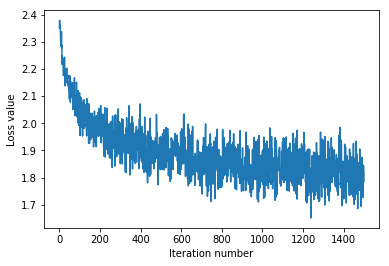

In [22]:
# Implement softmax.train() by filling in the code to extract a batch of data
# and perform the gradient step.
import time


tic = time.time()
loss_hist = softmax.train(X_train, y_train, learning_rate=1e-7,
                      num_iters=1500, verbose=True)
toc = time.time()
print('That took {}s'.format(toc - tic))

plt.plot(loss_hist)
plt.xlabel('Iteration number')
plt.ylabel('Loss value')
plt.show()

### Evaluate the performance of the trained softmax classifier on the validation data.

In [23]:
## Implement softmax.predict() and use it to compute the training and testing error.

y_train_pred = softmax.predict(X_train)
print(len(y_train_pred))
print('training accuracy: {}'.format(np.mean(np.equal(y_train,y_train_pred), )))
y_val_pred = softmax.predict(X_val)
print('validation accuracy: {}'.format(np.mean(np.equal(y_val, y_val_pred)), ))

49000
training accuracy: 0.3824489795918367
validation accuracy: 0.38


## Optimize the softmax classifier

You may copy and paste your optimization code from the SVM here.

In [24]:
np.finfo(float).eps

2.220446049250313e-16

Best learning rate:  3.1578947368421056e-06  Best Accuracy:  0.415 Err:  0.585
Test Acc:  0.378  Test Error:  0.622
Time took 419.63290762901306s


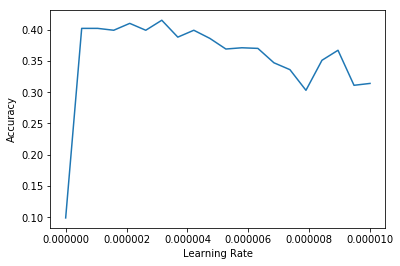

In [26]:
# ================================================================ #
# YOUR CODE HERE:
#   Train the Softmax classifier with different learning rates and 
#     evaluate on the validation data.
#   Report:
#     - The best learning rate of the ones you tested.  
#     - The best validation accuracy corresponding to the best validation error.
#
#   Select the SVM that achieved the best validation error and report
#     its error rate on the test set.
# ================================================================ #

my_time = time.time()
learning_rates = np.linspace(0, 1e-5, 20)
y_val_accs = []
best_learning_rate = -1
best_val_acc = -1

for rate in learning_rates:
    loss_hist = softmax.train(X_train, y_train, learning_rate=rate, num_iters=1500, verbose=False)
    y_train_pred = softmax.predict(X_train)
    train_acc = np.mean(np.equal(y_train, y_train_pred))
    y_val_pred = softmax.predict(X_val)
    y_val_acc = np.mean(np.equal(y_val, y_val_pred))
    y_val_accs.append(y_val_acc)
    if y_val_acc > best_val_acc:
        best_val_acc = y_val_acc
        best_learning_rate = rate
        
print("Best learning rate: ", best_learning_rate, " Best Accuracy: ", best_val_acc, "Err: ", 1 - best_val_acc)
    
loss_hist = softmax.train(X_train, y_train, learning_rate=best_learning_rate, num_iters=1500, verbose=False)
y_test_pred = softmax.predict(X_test)
test_acc = np.mean(np.equal(y_test, y_test_pred))

plt.plot(learning_rates, y_val_accs)
plt.xlabel('Learning Rate')
plt.ylabel('Accuracy')

print("Test Acc: ", test_acc, " Test Error: ", 1-test_acc)
# ================================================================ #
# END YOUR CODE HERE
# ================================================================ #

print("Time took {}s".format(time.time() - my_time))